In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.data_utils import drop_id

from src.utils.feature_eng_utils import (
    min_max_scale,
    simple_label_encoding,
    one_hot_encoding,
    get_binary_features,
    get_categorical_features,
    k_highest_features,
    random_forest_feature_selection
)

from src.utils.graph_utils import(
    display_multi_histoplot,
    display_multi_boxplot,
    display_categorical_plots,
    display_correlation,
) 
from src.utils.notebook_setup import setup_notebook_environment

# Quick setup
dbs, logger = await setup_notebook_environment()

# Now ready to work
logger.info("=== COMPREHENSIVE FEATURE SELECTION ===")

# Checking Silver Layer
silver_data = await dbs.get_silver_data()
silver_data_df = pd.DataFrame(silver_data)
silver_data_df = drop_id(silver_data_df)

silver_data_df.head(10)

2025-07-25 11:03:58,419 - api.services.database_service - INFO - Connected to MongoDB database: healthcare
2025-07-25 11:03:58,537 - src.utils.notebook_setup - INFO - Database connected: True
2025-07-25 11:03:58,538 - src.utils.notebook_setup - INFO - Database collections: ['heart_disease_gold', 'heart_disease_silver', 'heart_disease_bronze']
2025-07-25 11:03:58,539 - src.utils.notebook_setup - INFO - Database collections count: 3
2025-07-25 11:03:58,540 - src.utils.notebook_setup - INFO - === COMPREHENSIVE FEATURE SELECTION ===


,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,target
0,63.0,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0
1,67.0,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,1
2,67.0,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,1
3,37.0,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0
4,41.0,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0
5,56.0,Male,Cleveland,atypical angina,120.0,236.0,False,normal,178.0,False,0.8,upsloping,0
6,62.0,Female,Cleveland,asymptomatic,140.0,268.0,False,lv hypertrophy,160.0,False,3.6,downsloping,1
7,57.0,Female,Cleveland,asymptomatic,120.0,354.0,False,normal,163.0,True,0.6,upsloping,0
8,63.0,Male,Cleveland,asymptomatic,130.0,254.0,False,lv hypertrophy,147.0,False,1.4,flat,1
9,53.0,Male,Cleveland,asymptomatic,140.0,203.0,True,lv hypertrophy,155.0,True,3.1,downsloping,1


In [2]:
# Categorical Encoding
logger.info("Categorical Encoding using Label Encoder")

# Get binary features (both boolean and 2-value categorical)
binary_cols = get_binary_features(silver_data_df)
logger.info(f"Binary Columns to encode: {binary_cols}")

# Apply label encoding to binary features
silver_data_df = simple_label_encoding(silver_data_df, binary_cols)

# Get multi-class categorical features
categorical_cols = get_categorical_features(silver_data_df, exclude_binary=True)
logger.info(f"Multi-class Categorical Columns: {categorical_cols}")

# Apply one-hot encoding to multi-class categorical features
if categorical_cols:  # Only if there are multi-class categorical features
    silver_data_df = one_hot_encoding(silver_data_df, categorical_cols)

# Check final result
logger.info(f"Final dataset shape: {silver_data_df.shape}")
logger.info(f"Final columns: {list(silver_data_df.columns)}")
logger.info(f"Data types: {silver_data_df.dtypes.value_counts()}")

silver_data_df.head(20)

2025-07-25 11:03:59,388 - src.utils.notebook_setup - INFO - Categorical Encoding using Label Encoder
2025-07-25 11:03:59,392 - src.utils.feature_eng_utils - INFO - Boolean Columns: ['fbs', 'exang']
2025-07-25 11:03:59,411 - src.utils.feature_eng_utils - INFO - Final Binary Columns: ['fbs', 'exang', 'sex']
2025-07-25 11:03:59,413 - src.utils.notebook_setup - INFO - Binary Columns to encode: ['fbs', 'exang', 'sex']
2025-07-25 11:03:59,419 - src.utils.feature_eng_utils - INFO - Encoded fbs: [1 0]
2025-07-25 11:03:59,421 - src.utils.feature_eng_utils - INFO - Encoded exang: [0 1]
2025-07-25 11:03:59,431 - src.utils.feature_eng_utils - INFO - Encoded sex: [1 0]
2025-07-25 11:03:59,446 - src.utils.feature_eng_utils - INFO - Multi-class Categorical Columns: ['dataset', 'cp', 'restecg', 'slope']
2025-07-25 11:03:59,447 - src.utils.notebook_setup - INFO - Multi-class Categorical Columns: ['dataset', 'cp', 'restecg', 'slope']
2025-07-25 11:03:59,462 - src.utils.feature_eng_utils - INFO - One-hot

,age,sex,trestbps,chol,fbs,thalch,exang,oldpeak,target,dataset_Cleveland,...,cp_atypical angina,cp_non-anginal,cp_typical angina,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality,slope_downsloping,slope_flat,slope_not_tested,slope_upsloping
0,63.0,1,145.0,233.0,1,150.0,0,2.3,0,1,...,0,0,1,1,0,0,1,0,0,0
1,67.0,1,160.0,286.0,0,108.0,1,1.5,1,1,...,0,0,0,1,0,0,0,1,0,0
2,67.0,1,120.0,229.0,0,129.0,1,2.6,1,1,...,0,0,0,1,0,0,0,1,0,0
3,37.0,1,130.0,250.0,0,187.0,0,3.5,0,1,...,0,1,0,0,1,0,1,0,0,0
4,41.0,0,130.0,204.0,0,172.0,0,1.4,0,1,...,1,0,0,1,0,0,0,0,0,1
5,56.0,1,120.0,236.0,0,178.0,0,0.8,0,1,...,1,0,0,0,1,0,0,0,0,1
6,62.0,0,140.0,268.0,0,160.0,0,3.6,1,1,...,0,0,0,1,0,0,1,0,0,0
7,57.0,0,120.0,354.0,0,163.0,1,0.6,0,1,...,0,0,0,0,1,0,0,0,0,1
8,63.0,1,130.0,254.0,0,147.0,0,1.4,1,1,...,0,0,0,1,0,0,0,1,0,0
9,53.0,1,140.0,203.0,1,155.0,1,3.1,1,1,...,0,0,0,1,0,0,1,0,0,0


In [3]:
silver_data_df = min_max_scale(silver_data_df)
logger.info(f"shape: {silver_data_df.shape}")
silver_data_df.head(20)

2025-07-25 11:03:59,680 - src.utils.notebook_setup - INFO - shape: (19320, 24)


,age,sex,trestbps,chol,fbs,thalch,exang,oldpeak,target,dataset_Cleveland,...,cp_atypical angina,cp_non-anginal,cp_typical angina,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality,slope_downsloping,slope_flat,slope_not_tested,slope_upsloping
0,0.714286,1.0,0.541667,0.285714,1.0,0.633803,0.0,0.556818,0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.795918,1.0,0.666667,0.388031,0.0,0.338028,1.0,0.465909,1,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.795918,1.0,0.333333,0.277992,0.0,0.485915,1.0,0.590909,1,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.183673,1.0,0.416667,0.318533,0.0,0.894366,0.0,0.693182,0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.265306,0.0,0.416667,0.229730,0.0,0.788732,0.0,0.454545,0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.571429,1.0,0.333333,0.291506,0.0,0.830986,0.0,0.386364,0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
6,0.693878,0.0,0.500000,0.353282,0.0,0.704225,0.0,0.704545,1,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.591837,0.0,0.333333,0.519305,0.0,0.725352,1.0,0.363636,0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8,0.714286,1.0,0.416667,0.326255,0.0,0.612676,0.0,0.454545,1,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
9,0.510204,1.0,0.500000,0.227799,1.0,0.669014,1.0,0.647727,1,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


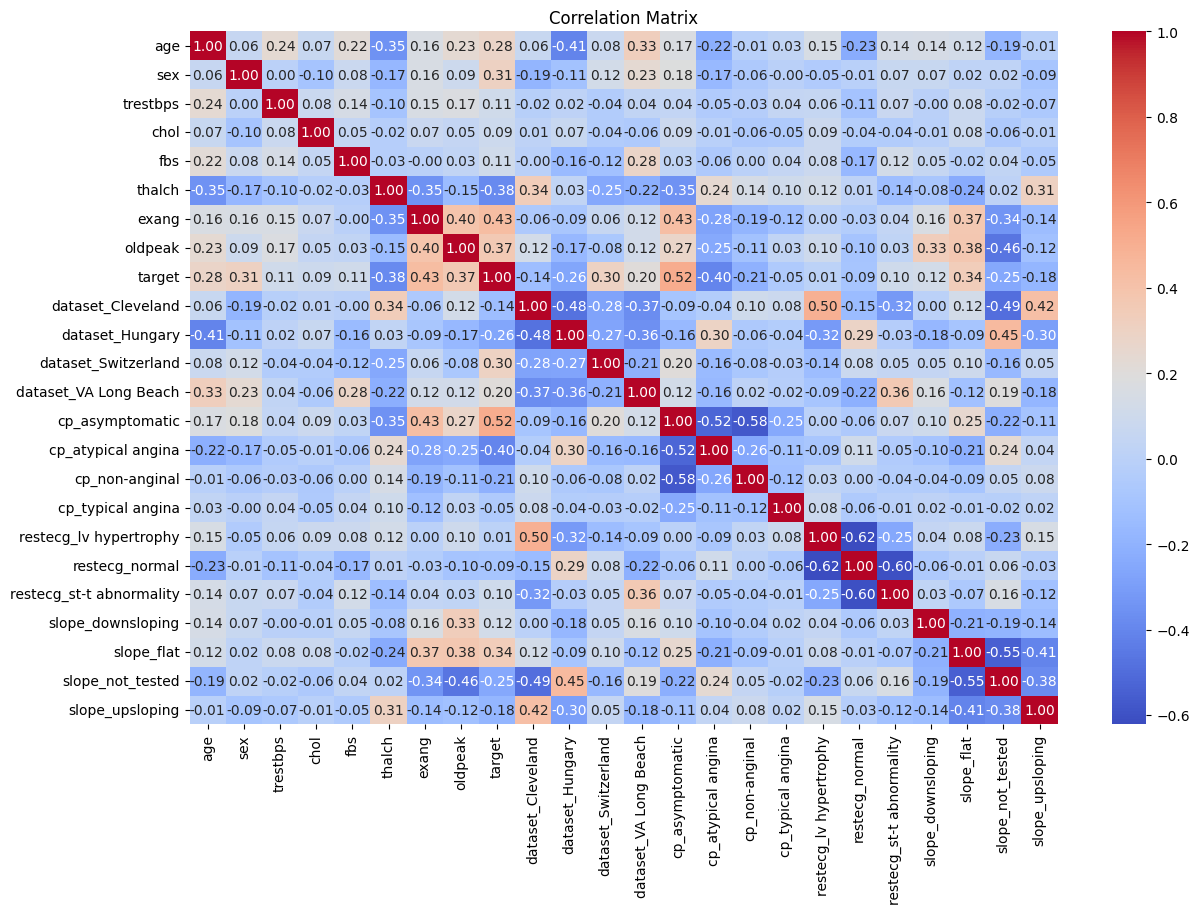

In [4]:
display_correlation(silver_data_df)

In [5]:
# Dropping all dataset_origin columns from one hot encoding, they are irrelevant
silver_data_df.columns

dataset_origin_col =  [col for col in silver_data_df.columns if 'dataset' in col]
silver_data_df = silver_data_df.drop(dataset_origin_col, axis=1)
logger.info(f"shape: {silver_data_df.shape}")
silver_data_df.head(10)

2025-07-25 11:04:01,975 - src.utils.notebook_setup - INFO - shape: (19320, 20)


,age,sex,trestbps,chol,fbs,thalch,exang,oldpeak,target,cp_asymptomatic,cp_atypical angina,cp_non-anginal,cp_typical angina,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality,slope_downsloping,slope_flat,slope_not_tested,slope_upsloping
0,0.714286,1.0,0.541667,0.285714,1.0,0.633803,0.0,0.556818,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.795918,1.0,0.666667,0.388031,0.0,0.338028,1.0,0.465909,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.795918,1.0,0.333333,0.277992,0.0,0.485915,1.0,0.590909,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.183673,1.0,0.416667,0.318533,0.0,0.894366,0.0,0.693182,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.265306,0.0,0.416667,0.229730,0.0,0.788732,0.0,0.454545,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.571429,1.0,0.333333,0.291506,0.0,0.830986,0.0,0.386364,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
6,0.693878,0.0,0.500000,0.353282,0.0,0.704225,0.0,0.704545,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.591837,0.0,0.333333,0.519305,0.0,0.725352,1.0,0.363636,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8,0.714286,1.0,0.416667,0.326255,0.0,0.612676,0.0,0.454545,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
9,0.510204,1.0,0.500000,0.227799,1.0,0.669014,1.0,0.647727,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [6]:
# STEP 1: Extract target variable FIRST (before feature selection)
logger.info("=== EXTRACTING TARGET VARIABLE ===")

# Extract target before any feature selection
y = silver_data_df['target'].copy()  # Save the target
X = silver_data_df.drop('target', axis=1)  # Features without target

logger.info(f"Target variable shape: {y.shape}")
logger.info(f"Features matrix shape: {X.shape}")
logger.info(f"Target value counts:\n{y.value_counts()}")


2025-07-25 11:04:02,034 - src.utils.notebook_setup - INFO - === EXTRACTING TARGET VARIABLE ===
2025-07-25 11:04:02,041 - src.utils.notebook_setup - INFO - Target variable shape: (19320,)
2025-07-25 11:04:02,043 - src.utils.notebook_setup - INFO - Features matrix shape: (19320, 19)
2025-07-25 11:04:02,045 - src.utils.notebook_setup - INFO - Target value counts:
target
1    10689
0     8631
Name: count, dtype: int64


In [7]:
logger.info("=== FEATURE SELECTION ===")

kbest_selected_features, kbest_rejected_features, kbest_scored_df = k_highest_features(
    silver_data_df,  # Complete dataframe with target
    target_col='target',  # Column name as string
    k=15
)

rf_selected_features, rf_rejected_features, rf_scored_df = random_forest_feature_selection(
    silver_data_df,  # Complete dataframe with target
    target_col='target',  # Column name as string
    k=15
)

logger.info("\nFEATURES FROM SELECT K BEST\n")
logger.info(f"SelectKBest selected: {len(kbest_selected_features)} features")
logger.info(f"RandomForest selected: {len(rf_selected_features)} features")

logger.info("\nSELECTED FEATURES:")
logger.info(kbest_selected_features)
logger.info("\nREJECTED FEATURES:")
logger.info(kbest_rejected_features)
logger.info("\nSCORED FEATURES:")
kbest_scored_df.head(10)

logger.info("\nSELECTED FEATURES:")
logger.info(rf_selected_features)
logger.info("\nREJECTED FEATURES:")
logger.info(rf_rejected_features)
logger.info("\nSCORED FEATURES:")
rf_scored_df.head(10)

2025-07-25 11:04:02,059 - src.utils.notebook_setup - INFO - === FEATURE SELECTION ===
2025-07-25 11:04:03,835 - src.utils.feature_eng_utils - INFO - Type: <class 'numpy.ndarray'>
2025-07-25 11:04:03,836 - src.utils.feature_eng_utils - INFO - Shape: (19,)
2025-07-25 11:04:03,838 - src.utils.feature_eng_utils - INFO - Sample scores: [0.06922767 0.05055547 0.05052307 0.20386584 0.        ]
2025-07-25 11:04:03,840 - src.utils.feature_eng_utils - INFO - 
FEATURE SELECTION MASK (which features were selected):
2025-07-25 11:04:03,841 - src.utils.feature_eng_utils - INFO - Type: <class 'numpy.ndarray'>
2025-07-25 11:04:03,842 - src.utils.feature_eng_utils - INFO - Shape: (19,)
2025-07-25 11:04:03,843 - src.utils.feature_eng_utils - INFO - 
SELECTED FEATURE NAMES:
2025-07-25 11:04:03,844 - src.utils.feature_eng_utils - INFO - Selected features: ['age', 'sex', 'trestbps', 'chol', 'thalch', 'exang', 'oldpeak', 'cp_asymptomatic', 'cp_atypical angina', 'cp_non-anginal', 'restecg_lv hypertrophy', 'r

,feature,importance
8,cp_asymptomatic,0.127392
5,thalch,0.122841
3,chol,0.121526
0,age,0.116356
7,oldpeak,0.092248
2,trestbps,0.085765
6,exang,0.073971
9,cp_atypical angina,0.056330
1,sex,0.043852
16,slope_flat,0.034803


In [8]:
# Find Convergent Features
logger.info("=== CONVERGENT FEATURE SELECTION ===")

convergent_rejected = []
clinical_baseline = ['age', 'sex']  # Always keep these

# Find features rejected by both methods
for feature in X.columns:  # Use X.columns, not silver_data_df.columns
    if (feature in rf_rejected_features and 
        feature in kbest_rejected_features and
        feature not in clinical_baseline and
        feature != 'target'):  # Extra safety check
        convergent_rejected.append(feature)

logger.info(f"Features rejected by BOTH methods: {convergent_rejected}")

# Features to keep (everything except convergent rejected)
features_to_keep = [col for col in X.columns if col not in convergent_rejected]
logger.info(f"Final features to keep: {len(features_to_keep)} features")
logger.info(f"Features: {features_to_keep}")

logger.info("=== EXTRACTING TARGET VARIABLE AFTER FEATURE SELECTION ===")

# Extract target after feature selection
y = silver_data_df['target'].copy()
X = silver_data_df.drop('target', axis=1)

logger.info(f"Target variable shape: {y.shape}")
logger.info(f"Features matrix shape: {X.shape}")
logger.info(f"Target value counts:\n{y.value_counts()}")



2025-07-25 11:04:04,965 - src.utils.notebook_setup - INFO - === CONVERGENT FEATURE SELECTION ===
2025-07-25 11:04:04,968 - src.utils.notebook_setup - INFO - Features rejected by BOTH methods: ['cp_typical angina', 'restecg_st-t abnormality', 'slope_downsloping']
2025-07-25 11:04:04,969 - src.utils.notebook_setup - INFO - Final features to keep: 16 features
2025-07-25 11:04:04,971 - src.utils.notebook_setup - INFO - Features: ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak', 'cp_asymptomatic', 'cp_atypical angina', 'cp_non-anginal', 'restecg_lv hypertrophy', 'restecg_normal', 'slope_flat', 'slope_not_tested', 'slope_upsloping']
2025-07-25 11:04:04,972 - src.utils.notebook_setup - INFO - === EXTRACTING TARGET VARIABLE AFTER FEATURE SELECTION ===
2025-07-25 11:04:04,976 - src.utils.notebook_setup - INFO - Target variable shape: (19320,)
2025-07-25 11:04:04,977 - src.utils.notebook_setup - INFO - Features matrix shape: (19320, 19)
2025-07-25 11:04:04,980 - src.utils.n

In [9]:
logger.info("=== CREATING GOLD LAYER ===")

# Create X with selected features only
X_selected = X[features_to_keep].copy()

# Create Gold layer by combining selected features + target
df_gold = X_selected.copy()
df_gold['target'] = y  # Add target back

logger.info(f"Gold layer shape: {df_gold.shape}")
logger.info(f"Gold layer columns: {list(df_gold.columns)}")

# Verify target was added correctly
logger.info(f"Target in Gold layer: {'target' in df_gold.columns}")
logger.info(f"Gold layer target distribution:\n{df_gold['target'].value_counts()}")

# Show sample of Gold layer
logger.info("Gold layer sample:")
df_gold.head()

2025-07-25 11:04:05,016 - src.utils.notebook_setup - INFO - === CREATING GOLD LAYER ===
2025-07-25 11:04:05,115 - src.utils.notebook_setup - INFO - Gold layer shape: (19320, 17)
2025-07-25 11:04:05,118 - src.utils.notebook_setup - INFO - Gold layer columns: ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak', 'cp_asymptomatic', 'cp_atypical angina', 'cp_non-anginal', 'restecg_lv hypertrophy', 'restecg_normal', 'slope_flat', 'slope_not_tested', 'slope_upsloping', 'target']
2025-07-25 11:04:05,120 - src.utils.notebook_setup - INFO - Target in Gold layer: True
2025-07-25 11:04:05,123 - src.utils.notebook_setup - INFO - Gold layer target distribution:
target
1    10689
0     8631
Name: count, dtype: int64
2025-07-25 11:04:05,125 - src.utils.notebook_setup - INFO - Gold layer sample:


,age,sex,trestbps,chol,fbs,thalch,exang,oldpeak,cp_asymptomatic,cp_atypical angina,cp_non-anginal,restecg_lv hypertrophy,restecg_normal,slope_flat,slope_not_tested,slope_upsloping,target
0,0.714286,1.0,0.541667,0.285714,1.0,0.633803,0.0,0.556818,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,0.795918,1.0,0.666667,0.388031,0.0,0.338028,1.0,0.465909,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
2,0.795918,1.0,0.333333,0.277992,0.0,0.485915,1.0,0.590909,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
3,0.183673,1.0,0.416667,0.318533,0.0,0.894366,0.0,0.693182,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
4,0.265306,0.0,0.416667,0.229730,0.0,0.788732,0.0,0.454545,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0


In [10]:
logger.info("=== SAVING TO GOLD LAYER MONGODB ===")

# Convert to records for MongoDB
gold_data = df_gold.to_dict('records')

logger.info(f"Converting {len(gold_data)} records to dict format")
logger.info(f"Sample record keys: {list(gold_data[0].keys())}")

# Insert into Gold layer
success = await dbs.insert_gold_data(gold_data)

if success:
    logger.info("Successfully saved Gold layer to MongoDB!")
    
    # Verify by reading back
    verification = await dbs.get_gold_data(limit=5)
    logger.info(f"Verification: Retrieved {len(verification)} records from Gold layer")
    
    if verification:
        logger.info(f"Sample Gold record: {verification[0]}")
        verification_df = pd.DataFrame(verification)
        logger.info("Verification sample:")
        verification_df.head(20)
        logger.info(verification_df.info())
        logger.info(verification_df.describe())
        logger.info(f"Verification shape: {verification_df.shape}")
else:
    logger.error("Failed to save Gold layer to MongoDB")

2025-07-25 11:04:05,163 - src.utils.notebook_setup - INFO - === SAVING TO GOLD LAYER MONGODB ===
2025-07-25 11:04:05,315 - src.utils.notebook_setup - INFO - Converting 19320 records to dict format
2025-07-25 11:04:05,317 - src.utils.notebook_setup - INFO - Sample record keys: ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak', 'cp_asymptomatic', 'cp_atypical angina', 'cp_non-anginal', 'restecg_lv hypertrophy', 'restecg_normal', 'slope_flat', 'slope_not_tested', 'slope_upsloping', 'target']
2025-07-25 11:04:10,960 - api.services.database_service - INFO - Inserted 19320 records into Gold layer
2025-07-25 11:04:10,962 - src.utils.notebook_setup - INFO - Successfully saved Gold layer to MongoDB!
2025-07-25 11:04:11,775 - src.utils.notebook_setup - INFO - Verification: Retrieved 5 records from Gold layer
2025-07-25 11:04:11,776 - src.utils.notebook_setup - INFO - Sample Gold record: {'_id': ObjectId('68839ce7e1701677468e612c'), 'age': 0.7142857142857142, 'sex': 1.0, 'tre

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   _id                     5 non-null      object 
 1   age                     5 non-null      float64
 2   sex                     5 non-null      float64
 3   trestbps                5 non-null      float64
 4   chol                    5 non-null      float64
 5   fbs                     5 non-null      float64
 6   thalch                  5 non-null      float64
 7   exang                   5 non-null      float64
 8   oldpeak                 5 non-null      float64
 9   cp_asymptomatic         5 non-null      float64
 10  cp_atypical angina      5 non-null      float64
 11  cp_non-anginal          5 non-null      float64
 12  restecg_lv hypertrophy  5 non-null      float64
 13  restecg_normal          5 non-null      float64
 14  slope_flat              5 non-null      float6

In [11]:
logger.info("=== SAVING FEATURE ENGINEERING METADATA ===")

import joblib
import json

# Create comprehensive metadata
feature_metadata = {
    'original_features': list(X.columns),
    'selected_features': features_to_keep,
    'convergent_rejected': convergent_rejected,
    'selectkbest_selected': kbest_selected_features,
    'rf_selected': rf_selected_features,
    'clinical_protected': clinical_baseline,
    'feature_counts': {
        'original': len(X.columns),
        'selected': len(features_to_keep),
        'removed': len(convergent_rejected)
    },
    'gold_layer_shape': df_gold.shape,
    'target_distribution': df_gold['target'].value_counts().to_dict()
}

# Save metadata

with open('../models/feature_engineering_metadata.json', 'w') as f:
    json.dump(feature_metadata, f)
logger.info("Saved feature engineering metadata")

2025-07-25 11:04:11,852 - src.utils.notebook_setup - INFO - === SAVING FEATURE ENGINEERING METADATA ===
2025-07-25 11:04:11,857 - src.utils.notebook_setup - INFO - Saved feature engineering metadata


In [12]:
# Final Summary
logger.info("="*60)
logger.info("FEATURE ENGINEERING COMPLETE - SUMMARY")
logger.info("="*60)

logger.info(f"Original features: {len(X.columns)}")
logger.info(f"Selected features: {len(features_to_keep)}")
logger.info(f"Removed features: {len(convergent_rejected)}")
logger.info(f"Gold layer shape: {df_gold.shape}")
logger.info(f"Target preserved: {df_gold['target'].notna().all()}")
logger.info(f"Data saved to MongoDB Gold collection")
logger.info(f"Metadata saved for model training")

logger.info(f"\nRemoved features: {convergent_rejected}")
logger.info(f"Final features: {features_to_keep}")

logger.info("\nREADY FOR MODEL TRAINING!")
logger.info("Next: Run 04_model_training.ipynb")

# %%
# OPTIONAL: Quick verification of Gold layer data
logger.info("=== GOLD LAYER VERIFICATION ===")

logger.info("Data types in Gold layer:")
logger.info(df_gold.dtypes)

logger.info("\nNumerical feature ranges (should be [0,1] from min-max scaling):")
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
for col in numerical_features:
    if col in df_gold.columns:
        logger.info(f"{col}: {df_gold[col].min():.3f} to {df_gold[col].max():.3f}")

logger.info("\nTarget distribution:")
logger.info(df_gold['target'].value_counts())

logger.info("Feature Engineering Complete!")

2025-07-25 11:04:11,870 - src.utils.notebook_setup - INFO - ============================================================
2025-07-25 11:04:11,873 - src.utils.notebook_setup - INFO - FEATURE ENGINEERING COMPLETE - SUMMARY
2025-07-25 11:04:11,875 - src.utils.notebook_setup - INFO - ============================================================
2025-07-25 11:04:11,877 - src.utils.notebook_setup - INFO - Original features: 19
2025-07-25 11:04:11,878 - src.utils.notebook_setup - INFO - Selected features: 16
2025-07-25 11:04:11,879 - src.utils.notebook_setup - INFO - Removed features: 3
2025-07-25 11:04:11,880 - src.utils.notebook_setup - INFO - Gold layer shape: (19320, 17)
2025-07-25 11:04:11,882 - src.utils.notebook_setup - INFO - Target preserved: True
2025-07-25 11:04:11,883 - src.utils.notebook_setup - INFO - Data saved to MongoDB Gold collection
2025-07-25 11:04:11,884 - src.utils.notebook_setup - INFO - Metadata saved for model training
2025-07-25 11:04:11,885 - src.utils.notebook_setup